# estimate $p(\theta_g\,|\,X)$ using a normalizing flow

More specifically, we'll be estimating 
$$p(M_{\rm gas}, M_*, V_{\rm max}, Z_*, R_* | M_g, M_r, M_i, M_z, \sigma_g, \sigma_r, \sigma_i, \sigma_z)$$


In [1]:
import os
import h5py 
import numpy as np

In [2]:
import torch
from sbi import utils as Ut
from sbi import inference as Inference

In [3]:
import corner as DFM
# --- plotting --- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

## load CAMELS data set

In [4]:
f = h5py.File('/Users/chahah/data/cgpop/tng.snap33.subfind.galaxies.LHC.hdf5', 'r')
props = f['props'][...].T
f.close()

In [5]:
props[:,6] = np.log10(props[:,6])
props[:,7] = np.log10(props[:,7])
props[:,13] = np.log10(props[:,13])
props[:,17] = np.log10(props[:,17])

/opt/anaconda3/envs/uhod/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


In [6]:
props = props[np.isfinite(props[:,6])]

In [7]:
# Om, s8, Asn1, Aagn1, Asn2, Aagn2, Mg, Mstar, Mbh, Mtot, Vmax, Vdisp, Zg, Zs, SFR, J, Vel, Rstar, Rtot, Rvmax,
# absmag U, B, V, K, g, r, i, z
lbls = [r'$\Omega_m$', r'$\sigma_8$', r'$A_{\rm SN1}$', r'$A_{\rm AGN1}$', r'$A_{\rm SN2}$', r'$A_{\rm AGN2}$', 
        r'$\log M_g$', r'$\log M_*$', r'$M_{\rm BH}$', r'$M_{\rm tot}$', r'$V_{\rm max}$', r'$V_{\rm disp}$', 
        r'$Z_g$', r'$\log Z_*$', 'SFR', 'J', 'V', r'$\log R_*$', r'$R_{\rm tot}$', r'$R_{\rm vmax}$', 
        r'$U$ absmag', r'$B$ absmag', r'$V$ absmag', r'$K$ absmag', r'$g$ absmag', r'$r$ absmag', r'$i$ absmag', 
        r'$z$ absmag']

In [8]:
icosmo = [0, 1, 2, 3, 4, 5] # cosmological/hydro parameters
igals = [6, 7, 10, 13, 17] # intrinsic properties of galaixes (Mg, M*, Vmax, Z*, R*)
iobs = [-4, -3, -2, -1]

## forward model noise into the predicted photometry

In [9]:
import astropy.table as aTable

In [10]:
nsa = aTable.Table.read('/Users/chahah/data/cgpop/nsa_v0_1_2.fits')

In [11]:
absmag_nsa = np.array(nsa['ABSMAG'].data)[:,3:] # g, r, i, z
ivar_absmag_nsa = np.array(nsa['AMIVAR'].data)[:,3:]

/opt/anaconda3/envs/uhod/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in power
  """Entry point for launching an IPython kernel.


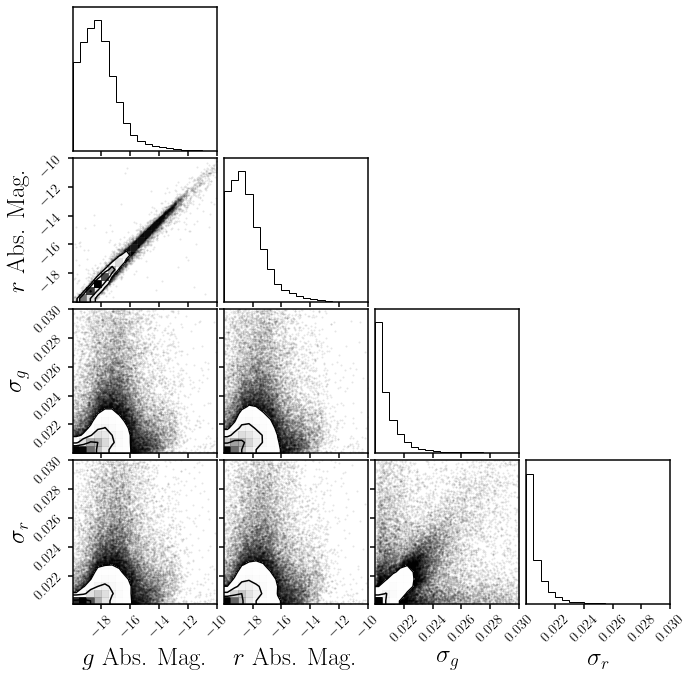

In [12]:
fig = DFM.corner(np.array([absmag_nsa[:,0], absmag_nsa[:,1], ivar_absmag_nsa[:,0]**-0.5, ivar_absmag_nsa[:,1]**-0.5]).T, 
                 labels=['$g$ Abs. Mag.', '$r$ Abs. Mag.', '$\sigma_g$', '$\sigma_r$'], label_kwargs={'fontsize': 25},
                 range=[(-20., -10.), (-20., -10.), (0.02, 0.03), (0.02, 0.03)])

In [13]:
absmag_sigmas = np.random.uniform(0.02, 0.03, size=(props.shape[0], len(iobs)))
absmags = props[:,np.array(iobs)] + absmag_sigmas * np.random.normal(size=(props.shape[0], len(iobs)))

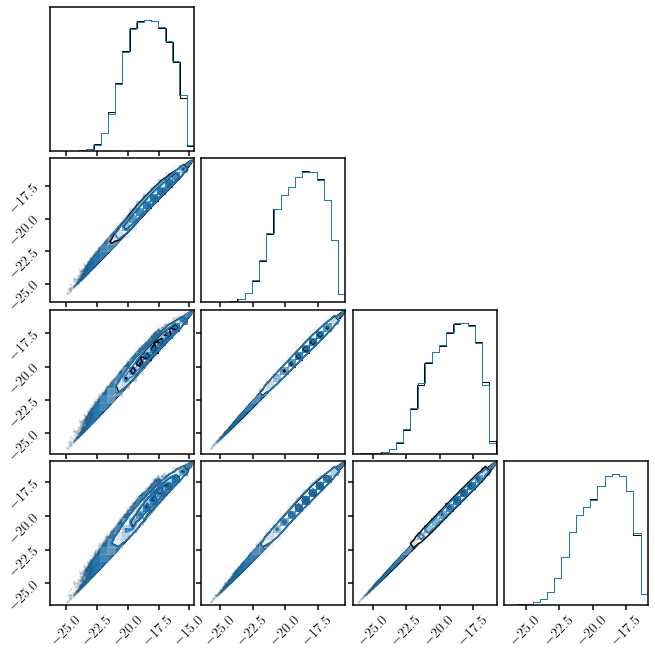

In [14]:
fig = DFM.corner(absmags, color='k')
_ = DFM.corner(props[:,np.array(iobs)], color='C0', fig=fig)

# $p(M_{\rm gas}, M_*, V_{\rm max}, Z_*, R_* , M_g, M_r, M_i, M_z, \sigma_g, \sigma_r, \sigma_i, \sigma_z)$


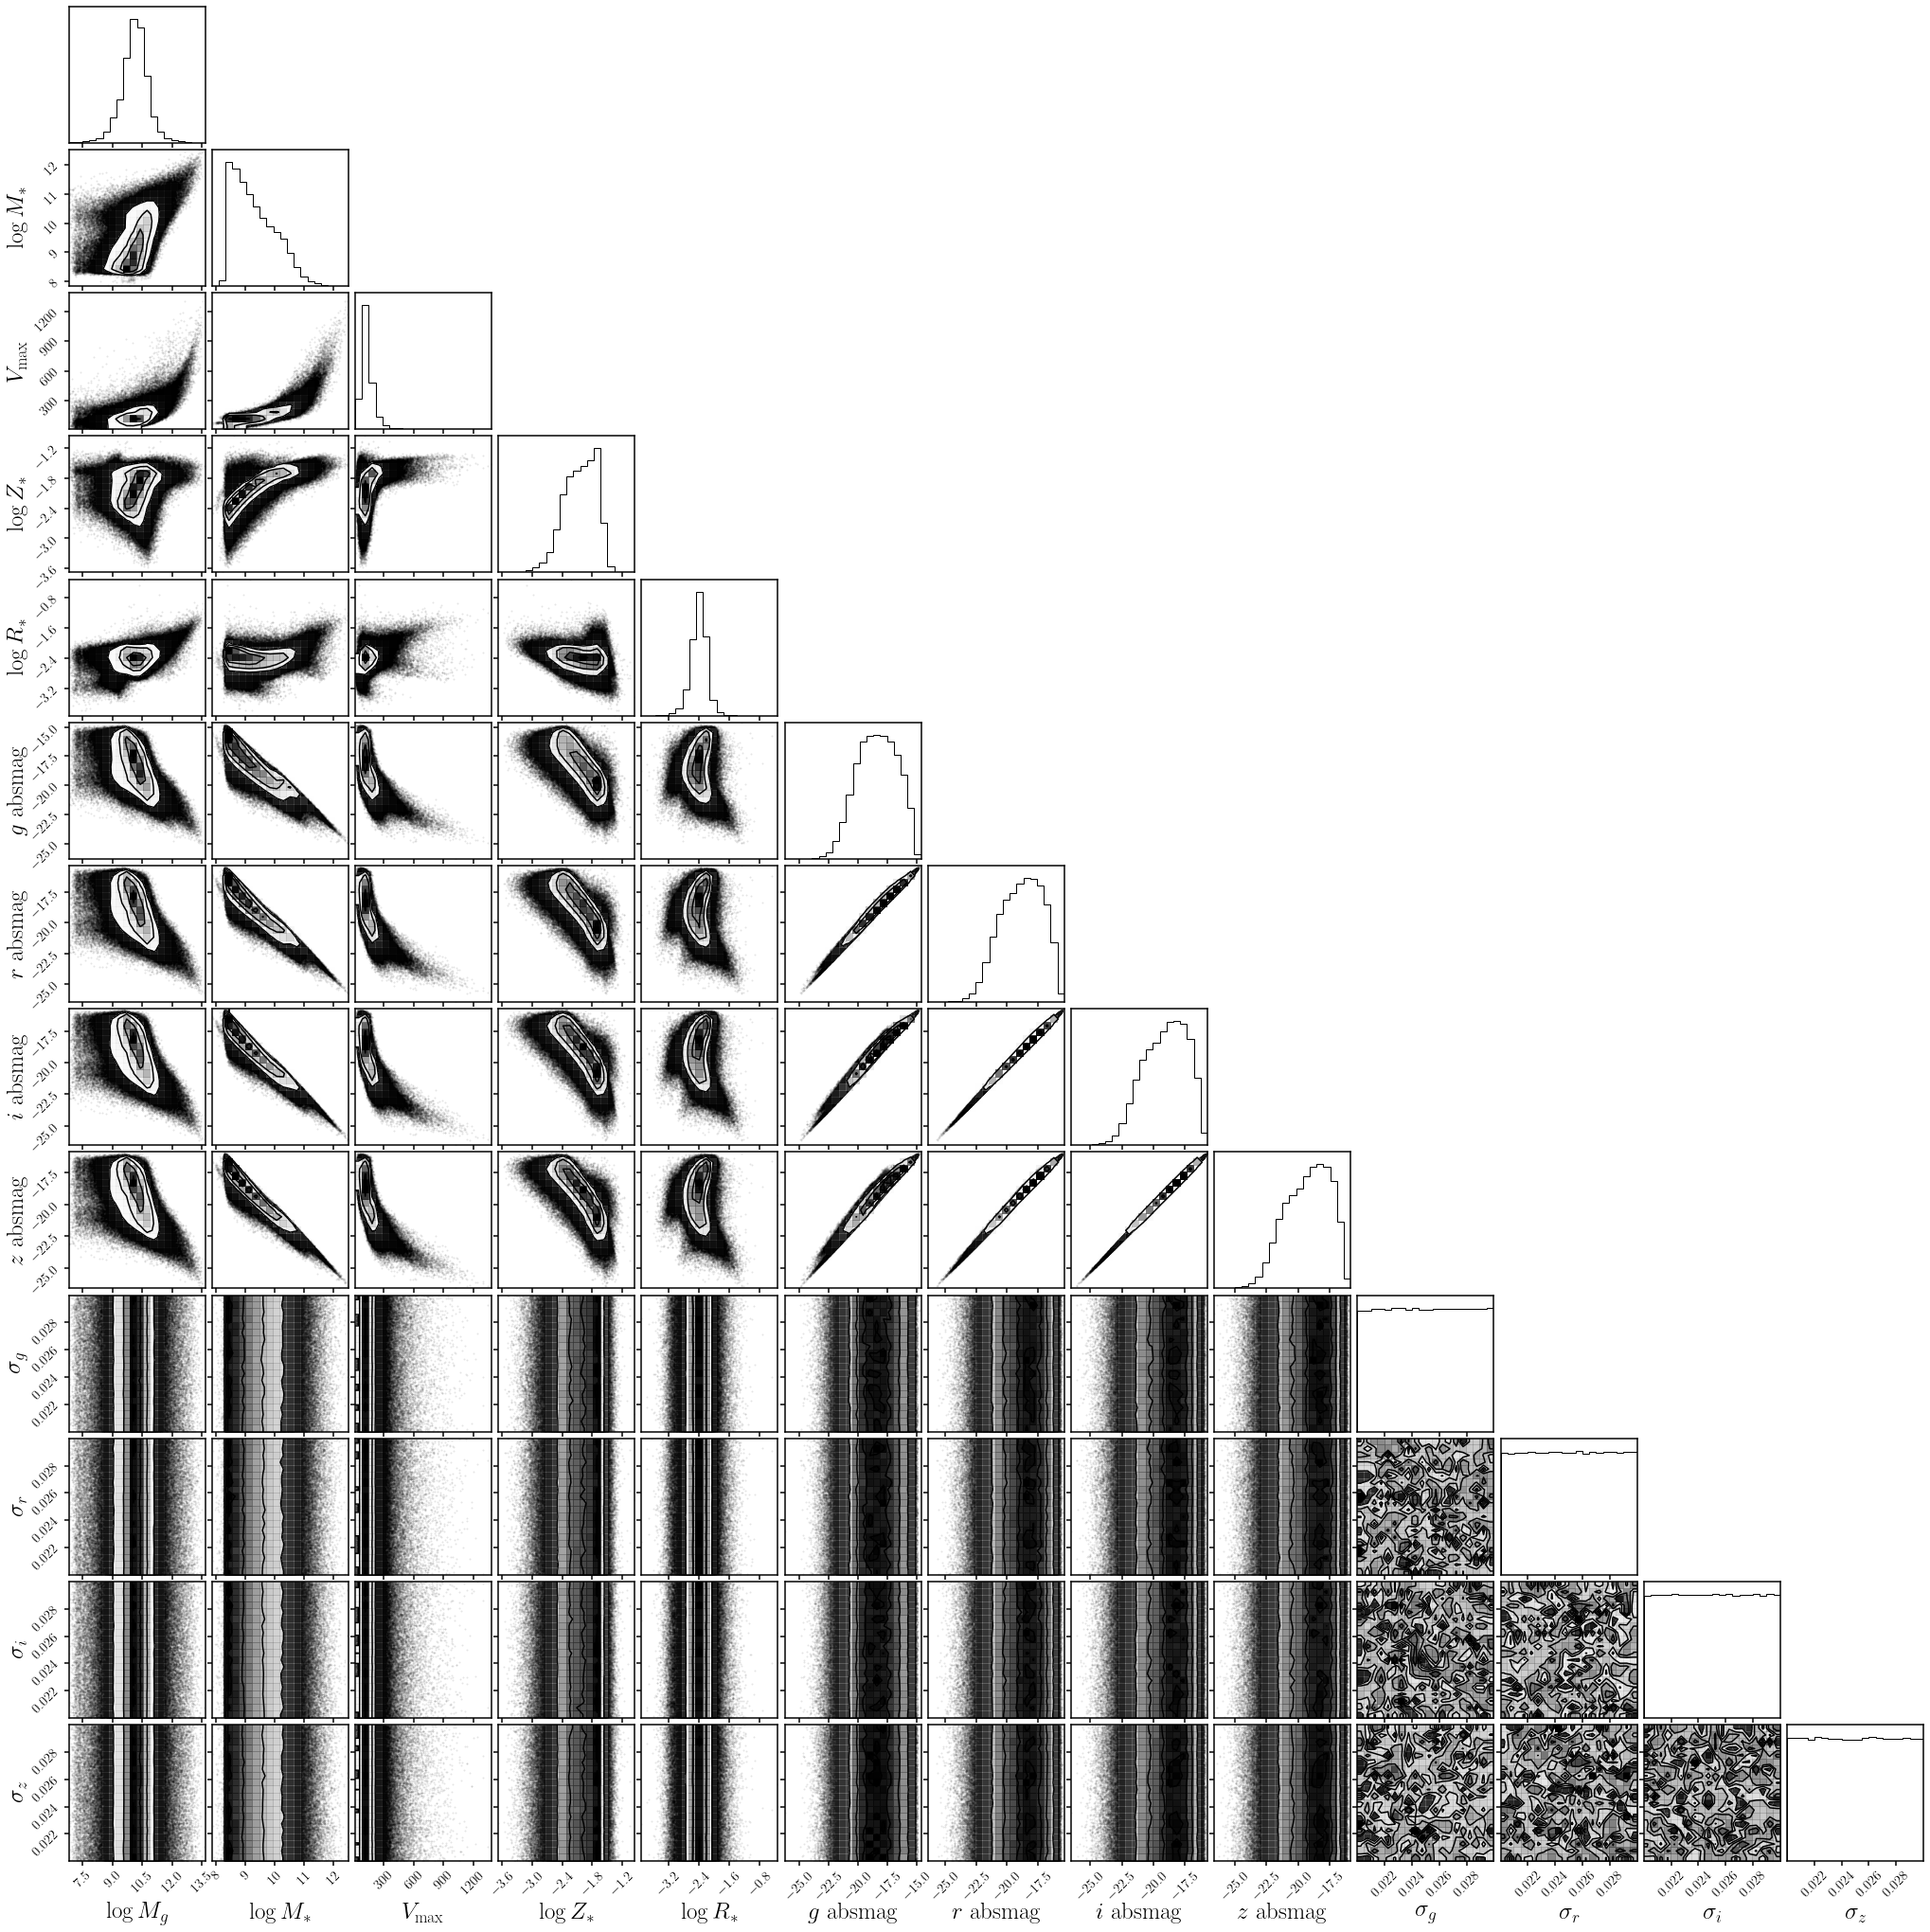

In [15]:
fig = DFM.corner(np.concatenate([props[:,igals], absmags, absmag_sigmas], axis=1),
                 labels=[lbls[i] for i in igals + iobs]+[r'$\sigma_g$', r'$\sigma_r$', r'$\sigma_i$', r'$\sigma_z$'],
                 label_kwargs={'fontsize': 25})

# train normalizing flow

In [16]:
prior_low = [6.81, 7.85, 12.89, -3.67, -3.919]
prior_high = [13.65, 12.51, 1400, 0, 0]
lower_bounds = torch.tensor(prior_low)
upper_bounds = torch.tensor(prior_high)

prior = Ut.BoxUniform(low=lower_bounds, high=upper_bounds, device='cpu')

In [19]:
ishuffle = np.arange(props.shape[0])
np.random.shuffle(ishuffle)

N_train = int(0.8 * props.shape[0])
x_train = np.concatenate([absmags, absmag_sigmas], axis=1)[ishuffle[:N_train]]
y_train = props[:,igals][ishuffle[:N_train]]

N_test = props.shape[0] - N_train
x_test = np.concatenate([absmags, absmag_sigmas], axis=1)[ishuffle[N_train:]]
y_test = props[:,igals][ishuffle[N_train:]]

In [ ]:
nhidden = 256
nblocks = 5

anpe = Inference.SNPE(prior=prior, 
                      density_estimator=Ut.posterior_nn('maf', hidden_features=nhidden, num_transforms=nblocks), 
                      device='cpu')
anpe.append_simulations(
    torch.as_tensor(y_train.astype(np.float32)), 
    torch.as_tensor(x_train.astype(np.float32)))

p_y_x_estimator = anpe.train()
qphi = anpe.build_posterior(p_y_x_estimator)

## validate normalizing flow

In [ ]:
rank_thetas = [] 
for i in range(1000): #x_test.shape[0]): 
    # sample posterior p(theta | x_test_i)
    y_prime = qphi.sample((10000,), 
            x=torch.as_tensor(x_test[i].astype(np.float32)).to('cpu'), 
            show_progress_bars=False)
    y_prime = np.array(y_prime.detach().to('cpu'))

    # calculate percentile score and rank
    rank_theta = []
    for itheta in range(y_test.shape[1]): 
        rank_theta.append(np.sum(y_prime[:,itheta] < y_test[i,itheta]))
    rank_thetas.append(rank_theta)

In [ ]:
fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)
for i in range(y_test.shape[1]): 
    _ = sub.hist(np.array(rank_thetas)[:,i]/10000, 
                 range=(0, 1), bins=20, histtype='step', 
                 linewidth=2, label=lbls[igals[i]])
sub.legend(loc='upper left', fonstize=20)
sub.set_xlabel('rank statistics', fontsize=25)
sub.set_xlim(0., 1.)
sub.set_ylim(0., 200.)
sub.set_yticks([])